<a href="https://colab.research.google.com/github/dmaresza/tensorflow_course/blob/main/04_TensorFlow_Transfer_Learning_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Feature Extraction

## 1. Build and fit a model using the "10% of 10 classes" data but with the [MobileNetV2](https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/100-224-feature-vector/1?tfhub-redirect=true) architecture feature extraction from TensorFlow Hub. How does it perform compared to our other models?

In [1]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

!rm 10_food_classes_10_percent.zip

--2024-07-08 21:11:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.9MB/s    in 9.4s    

2024-07-08 21:11:51 (17.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=(128, 128),
                                                          batch_size=32,
                                                          class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(128, 128),
                                             batch_size=32,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"

# Download the pretrained model and save it as a Keras layer
feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False, # freeze the already-learned patterns
                                         name="feature_extraction_layer",
                                         input_shape=(128, 128, 3))

# Create model
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(10, activation="softmax", name="output_layer")
])

# Compile model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 18s 560ms/step - loss: 2.4447 - accuracy: 0.2613 - val_loss: 1.5935 - val_accuracy: 0.4696
Epoch 2/5
24/24 [==============================] - 7s 299ms/step - loss: 1.2741 - accuracy: 0.5987 - val_loss: 1.2620 - val_accuracy: 0.5796
Epoch 3/5
24/24 [==============================] - 8s 326ms/step - loss: 0.9377 - accuracy: 0.6987 - val_loss: 1.1621 - val_accuracy: 0.6188
Epoch 4/5
24/24 [==============================] - 12s 513ms/step - loss: 0.7616 - accuracy: 0.7587 - val_loss: 1.1665 - val_accuracy: 0.6168
Epoch 5/5
24/24 [==============================] - 7s 289ms/step - loss: 0.6411 - accuracy: 0.8093 - val_loss: 1.1194 - val_accuracy: 0.6316


In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              1692489   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 1702509 (6.49 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


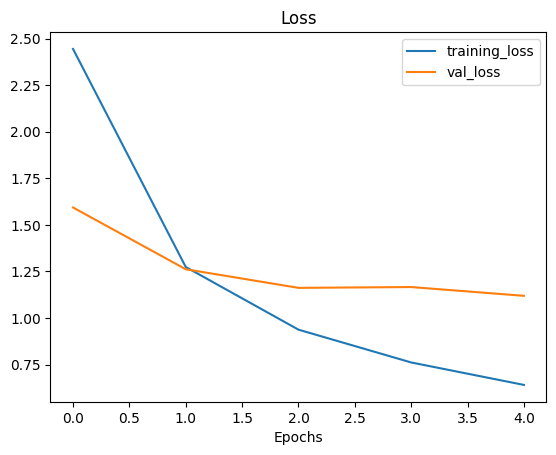

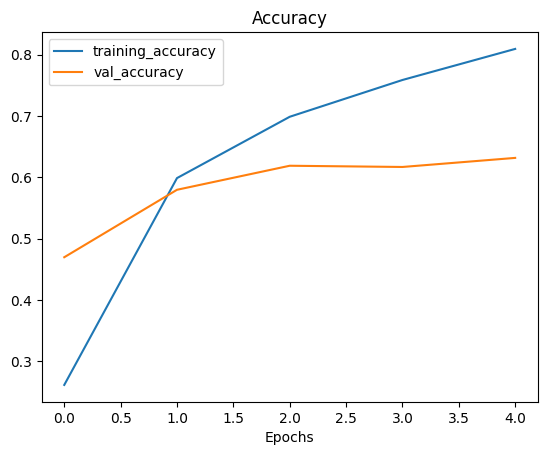

In [8]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

epochs = range(len(history.history["loss"]))

# Plot loss
plt.plot(epochs, loss, label="training_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label="training_accuracy")
plt.plot(epochs, val_accuracy, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

The models used previously were the ResnetV250 and the EfficientNetB0 models. After training for 5 epochs on the same dataset, the ResnetV250 feature extractor model achieved a ~78% test accuracy on the test data and the EfficientNetB0 feature extractor model achieved ~86% accuracy on the test data. This MobileNetV2 feature extractor model only achieved a 63% accuracy on the test data after 5 epochs, but the model is significantly smaller than the other two, having ~40% of the parameters of the EfficientNetB0 model and only ~7% of the parameters of the ResNetV250 model.

## 2. Name 3 different image classification models on TensorFlow Hub that we haven't used.

1. Vision Transformer
2. Inception V3
3. Cropnet

## 3. Build a model to classify images of two different things you've taken photos of.

* You can use any feature extraction layer from TensorFlow Hub you'd like for this.
* You should aim to have at least 10 images of each class. For example, to build a fridge vs. oven classifier, you'll want 10 images of fridges and 10 images of ovens.

In [11]:
# Getting images of pizza and steak
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

!rm pizza_steak.zip

--2024-07-08 21:33:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  23.1MB/s    in 5.7s    

2024-07-08 21:33:39 (18.4 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [12]:
import os
import random

# Get 10 random images from each class
random_pizza_images = random.sample(os.listdir("pizza_steak/train/pizza"), 10)
random_steak_images = random.sample(os.listdir("pizza_steak/train/steak"), 10)

os.makedirs("binary_classification/pizza", exist_ok=True)
os.makedirs("binary_classification/steak", exist_ok=True)

# Move images to new directory
for path in random_pizza_images:
  pathname = "pizza_steak/train/pizza/" + path
  !mv {pathname} binary_classification/pizza/

for path in random_steak_images:
  pathname = "pizza_steak/train/steak/" + path
  !mv {pathname} binary_classification/steak/

# Remove rest of images
!rm -rf pizza_steak

In [13]:
train_datagen_binary = ImageDataGenerator(rescale=1/255.,
                                   validation_split=0.5)

train_data_binary = train_datagen_binary.flow_from_directory("binary_classification",
                                                             batch_size=2,
                                                             target_size=(224, 224),
                                                             class_mode='binary',
                                                             subset='training')

valid_data_binary = train_datagen_binary.flow_from_directory("binary_classification",
                                                             batch_size=2,
                                                             target_size=(224, 224),
                                                             class_mode='binary',
                                                             subset='validation')

Found 10 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [14]:
effnetv2_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"

model_2 = tf.keras.Sequential([
    hub.KerasLayer(effnetv2_url,
                   trainable=False,
                   name="feature_extraction_layer",
                   input_shape=(224, 224, 3)),
    layers.Dense(1, activation="sigmoid")
])

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data_binary,
                        epochs=5,
                        steps_per_epoch=len(train_data_binary),
                        validation_data=valid_data_binary,
                        validation_steps=len(valid_data_binary))

Epoch 1/5
5/5 [==============================] - 9s 242ms/step - loss: 1.3845 - accuracy: 0.6000 - val_loss: 0.9035 - val_accuracy: 0.4000
Epoch 2/5
5/5 [==============================] - 0s 41ms/step - loss: 0.7928 - accuracy: 0.6000 - val_loss: 0.7614 - val_accuracy: 0.4000
Epoch 3/5
5/5 [==============================] - 0s 52ms/step - loss: 0.5015 - accuracy: 0.7000 - val_loss: 0.6416 - val_accuracy: 0.5000
Epoch 4/5
5/5 [==============================] - 0s 53ms/step - loss: 0.3413 - accuracy: 0.9000 - val_loss: 0.5062 - val_accuracy: 0.7000
Epoch 5/5
5/5 [==============================] - 0s 55ms/step - loss: 0.1927 - accuracy: 1.0000 - val_loss: 0.4137 - val_accuracy: 0.9000


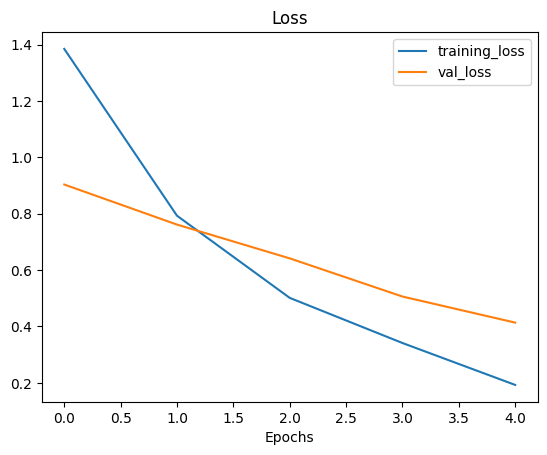

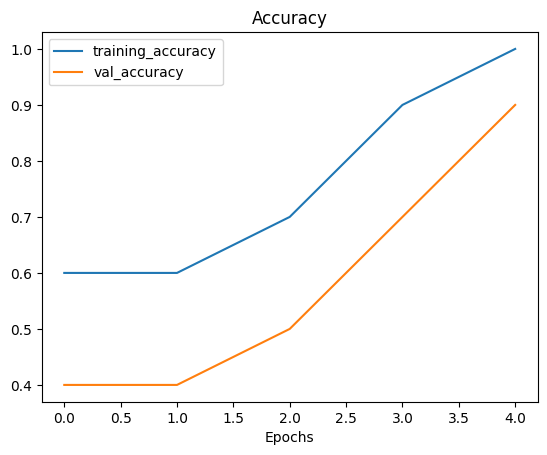

In [15]:
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]

accuracy = history_2.history["accuracy"]
val_accuracy = history_2.history["val_accuracy"]

epochs = range(len(history_2.history["loss"]))

# Plot loss
plt.plot(epochs, loss, label="training_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label="training_accuracy")
plt.plot(epochs, val_accuracy, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

It seems that the EfficientNetB2 feature extractor model works very well on the pizza/steak data, with only 10 training images and 10 testing images.

## 4. What is the current best performing model on ImageNet?

* Hint: you might want to check [Papers With Code](https://paperswithcode.com) for this.

It seems that the current best performing model on the ImageNet dataset is a model called OmniVec that uses a Vision Transformer (ViT) model architecture.